In [61]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
from astropy.io import fits
from astropy.wcs import WCS

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist, save_cutouts
from desi_lowz_funcs import find_objects_nearby, process_img, sdss_rgb
# from construct_dwarf_galaxy_catalogs import process_sga_matches
from catalog_paper_plots import make_bar_pie

## make a plot of read dwarfs with robust photometry 

# from construct_dwarf_galaxy_catalogs import process_sga_VI_catalog



# %load_ext autoreload
# %autoreload 2

In [2]:
# Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")

In [296]:
sga_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_sga_matched_dwarfs.fits")


In [297]:
sga_cat[sga_cat["TARGETID"] == 39627703925606400]

<Table length=0>
TARGETID SURVEY PROGRAM HEALPIX ...  SGA_GR SGA_LOGM_SAGA SAMPLE PCNN_FRAGMENT
                                ...                                           
 int64   bytes7  bytes6  int32  ... float64    float64    bytes3    float64   
-------- ------ ------- ------- ... ------- ------------- ------ -------------

In [3]:
## conver the line of sight velocity to the galactic center of frame velocity?

# Vgsr (km/s) is the galactic standard of rest velocity; referenced to the center of the Galaxy assuming a circular velocity of Sun of 239 km/s plus local solar motion (van der Marel et al. 2012): 
#Vgsr = Vhelio + 11.1 cos(l) cos(b) + 251 sin(l) cos(b) + 7.25 sin(b)

# Example RA, Dec in degrees (ICRS / J2000.0)
ra = sga_cat["RA"].data   # degrees
dec = sga_cat["DEC"].data  # degrees

# Create a SkyCoord object
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

# Convert to Galactic coordinates
l = c.galactic.l.deg  # Galactic longitude
b = c.galactic.b.deg  # Galactic latitude

sga_cat["l_rad"] = np.radians(l)
sga_cat["b_rad"] = np.radians(b)

c_light = 299792 #km/s

vhelio = sga_cat["Z"] * c_light 

sga_cat["V_HELIO"] = vhelio


In [293]:
ra = np.array([207.214])
dec = np.array([-6.3407])

# Create a SkyCoord object
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')

# Convert to Galactic coordinates
l = c.galactic.l.deg  # Galactic longitude
b = c.galactic.b.deg  # Galactic latitude

print(l,b)

c_light = 300000

vhelio = 0.0048 * c_light 

[327.56652333] [53.76210847]


In [294]:
vhelio

1439.9999999999998

In [295]:
vhelio_to_vgsr(vhelio, np.radians(l), np.radians(b) )

array([1371.80876582])

In [287]:

def vhelio_to_vgsr(vhelio, l_rad, b_rad):
    '''
    # Vgsr (km/s) is the galactic standard of rest velocity; referenced to the center of the Galaxy assuming a circular velocity of Sun of 239 km/s plus local solar motion (van der Marel et al. 2012): 
    #Vgsr = Vhelio + 11.1 cos(l) cos(b) + 251 sin(l) cos(b) + 7.25 sin(b)
    '''
    return vhelio + 11.1*np.cos(l_rad)*np.cos(b_rad) + 251*np.sin(l_rad)*np.cos(b_rad) + 7.25*np.sin(b_rad) 

In [4]:

def vhelio_to_vgsr(vhelio, l_rad, b_rad):
    '''
    # Vgsr (km/s) is the galactic standard of rest velocity; referenced to the center of the Galaxy assuming a circular velocity of Sun of 239 km/s plus local solar motion (van der Marel et al. 2012): 
    #Vgsr = Vhelio + 11.1 cos(l) cos(b) + 251 sin(l) cos(b) + 7.25 sin(b)
    '''
    return vhelio + 11.1*np.cos(l_rad)*np.cos(b_rad) + 251*np.sin(l_rad)*np.cos(b_rad) + 7.25*np.sin(b_rad) 


def vhelio_to_vcmb(vhelio, l_rad, b_rad, l0 = 264.021, b0 = 48.253, v0_cmb_dipole  =369.82):
    '''
    Converting the heliocentric redshift to CMB frame redshift. Equation 7 in this paper: https://arxiv.org/pdf/2110.03487
    '''

    z_helio = vhelio/c_light

    l0_rad = np.radians(l0)
    b0_rad = np.radians(b0)
    
    term = 1 - ( (v0_cmb_dipole/c_light) * (np.sin(b_rad)*np.sin(b0_rad) + np.cos(b_rad)*np.cos(b0_rad)*np.cos(l_rad - l0_rad) ) )
    
    z_cmb = (1 + z_helio) / term   - 1

    return z_cmb * c_light


In [5]:
sga_cat["V_CMB"] = vhelio_to_vcmb(vhelio, sga_cat["l_rad"], sga_cat["b_rad"] )
sga_cat["Z_CMB"] = sga_cat["V_CMB"] / c_light
sga_cat["V_GSR"] = vhelio_to_vgsr(vhelio, sga_cat["l_rad"], sga_cat["b_rad"])

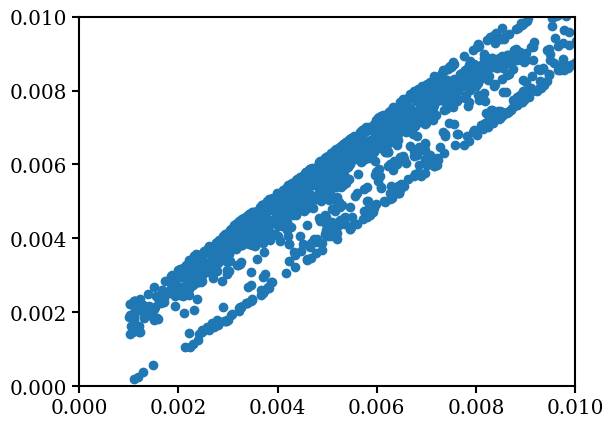

In [6]:
plt.scatter(sga_cat["Z"],sga_cat["Z_CMB"])
plt.xlim([0,0.01])
plt.ylim([0,0.01])
plt.show()

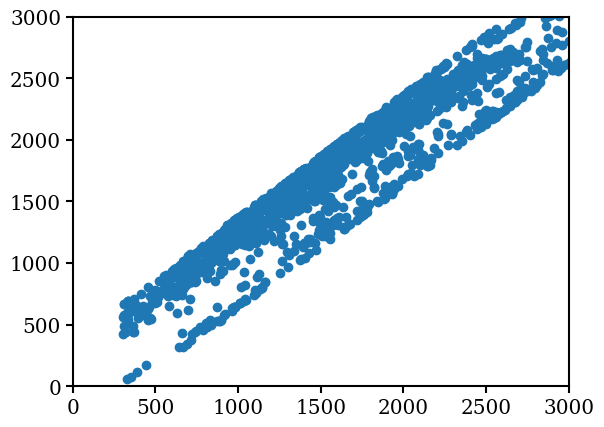

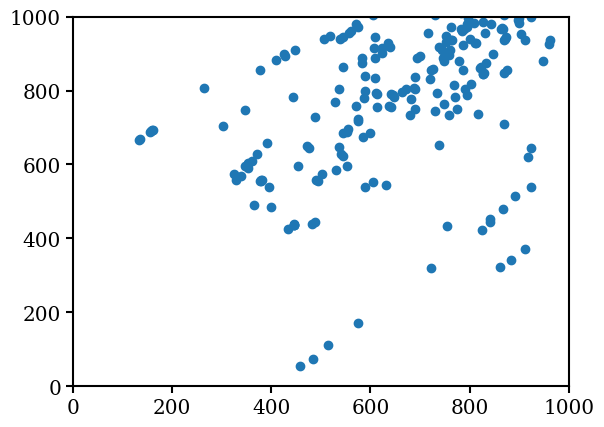

In [7]:
plt.scatter(sga_cat["V_HELIO"],sga_cat["V_CMB"])
plt.xlim([0,3000])
plt.ylim([0,3000])
plt.show()


plt.scatter(sga_cat["V_GSR"],sga_cat["V_CMB"])
plt.xlim([0,1000])
plt.ylim([0,1000])
plt.show()


In [8]:
##applying the NAM cutoff
sga_temp = sga_cat[ sga_cat["V_HELIO"] < 2850]


In [9]:
print(len(sga_temp))
from construct_dwarf_galaxy_catalogs import get_corrected_distances

1741


ImportError: cannot import name 'get_corrected_distances' from 'construct_dwarf_galaxy_catalogs' (/global/u1/v/virajvm/DESI2_LOWZ/desi_dwarfs/code/construct_dwarf_galaxy_catalogs.py)

In [10]:
fidu_dists,extra_dists = get_corrected_distances(sga_temp, chunk_size=500,calc_type = "NAM")
sga_temp["DIST_MPC"] = fidu_dists

NameError: name 'get_corrected_distances' is not defined

In [96]:
sga_temp = sga_temp[sga_temp["DIST_MPC"]  > 0]

print(len(sga_temp))

1697


In [97]:
from desi_lowz_funcs import get_stellar_mass

In [98]:
sga_temp["Z_CMB"].min(), sga_temp["DIST_MPC"].min()

(0.00018313155712723628, 3.0588609596360357)

In [99]:
lumi_dist = Planck18.luminosity_distance(sga_temp["Z_CMB"]).data
sga_mstar_lumi_dist = get_stellar_mass(sga_temp["SGA_GR"].data, sga_temp["SGA_R_COG_MAG"].data, sga_temp["Z_CMB"].data, d_in_mpc=None,input_zred=True)
sga_mstar_nam_dist = get_stellar_mass(sga_temp["SGA_GR"].data, sga_temp["SGA_R_COG_MAG"].data, sga_temp["Z_CMB"].data, d_in_mpc=sga_temp["DIST_MPC"].data,input_zred=False)


In [100]:
sga_mstar_lumi_dist[:5]

array([7.81253942, 8.52882441, 7.78009745, 7.95432803, 7.26660254])

In [101]:
sga_mstar_nam_dist[:5]

array([7.75206951, 8.54078454, 7.88622027, 7.95137429, 7.48109171])

In [102]:
import cmasher as cmr
from scipy.stats import median_abs_deviation

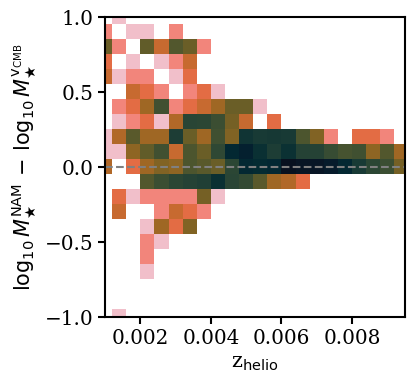

In [125]:
fig,ax = make_subplots(ncol = 1, nrow = 1,return_fig=True)


ax[0].hist2d(sga_temp["Z"].data,   sga_mstar_lumi_dist - sga_mstar_nam_dist,cmap = cmr.dusk_r,
           bins = 25, range=( (0,0.01), (-1.25,1.25) ), 
             rasterized=True, norm=LogNorm(vmin=1,vmax=100)  )

ax[0].axhline(y = 0,color = "gray",ls ="--")

ax[0].set_ylim([-1,1])
ax[0].set_xlim([0.001,0.0095])
ax[0].set_xlabel(r"z$_{\rm helio}$",fontsize = 15)
ax[0].set_ylabel(r"$\log_{10} M_{\bigstar}^{\rm NAM} \, - \, \log_{10} M_{\bigstar}^{\rm v_{\rm CMB}}$",fontsize = 15)

plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/nam_lumi_dist.pdf",bbox_inches="tight")

plt.show()

In [126]:
# fig,ax = make_subplots(ncol = 1, nrow = 1,return_fig=True)

# ax[0].hist2d(sga_mstar_lumi_dist.data,sga_mstar_nam_dist.data,cmap = cmr.dusk_r, bins = 25, range=( (6,9), (6,9) ), 
#              rasterized=True, norm=LogNorm(vmin=1,vmax=100) )

# ax[0].set_xlim([6,9])
# ax[0].set_ylim([6,9])
# ax[0].plot([6,9],[6,9],color = "gray",ls = "--")
# ax[0].set_xlabel(r"$\log_{10} M_{\bigstar}$ (ignoring PV)",fontsize = 15)
# ax[0].set_ylabel(r"$\log_{10} M_{\bigstar}$ (NAM Distance)",fontsize = 15)


# mstar_std = median_abs_deviation(sga_mstar_lumi_dist - sga_mstar_nam_dist, scale ="normal")
# dist_std = median_abs_deviation(lumi_dist - sga_temp["DIST_MPC"].data, scale = "normal")

# fs = 14

# ax[0].text( 0.325, 0.79, f"$\\sigma(\\log_{{10}} M_{{\\bigstar}}) \\sim {mstar_std:.2f}$", 
#            transform=ax[0].transAxes, va="center",ha="center",fontsize = fs)

# ax[0].text( 0.325, 0.89, f"$\\sigma(D_{{\\mathrm{{Mpc}}}}) \\sim {dist_std:.1f}$ Mpc", 
#            transform=ax[0].transAxes, va="center",ha="center",fontsize = fs)

# # plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/nam_lumi_dist.pdf",bbox_inches="tight")

# plt.show()

## SGA STUFF SEC. 4.6

In [4]:
# bgsb_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_bgs_bright_filter_zsucc_zrr02_allfracflux_W_SGA.fits")
# bgsf_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_bgs_faint_filter_zsucc_zrr03_allfracflux_W_SGA.fits")

In [5]:
sga_all_bad = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_SGA_ALL_BAD.fits")
print(len(sga_all_bad))
print(len(sga_all_bad[sga_all_bad["LOGM_SAGA_FIDU"] < 9.25]))


301
301


In [7]:
# sga_all_bad[:500]
# sga_all_bad[sga_all_bad["TARGETID"] == 39627649504514066]

In [10]:
# print_radecs(sga_all_bad["RA","DEC"], ra="RA",dec="DEC", num=500)

In [108]:
# IN VI'ing the all bad, we are just selecting galaxies that are plausibly dwarf galaxies
## we VI'ed likely possible dwarfs and removed all objets!!

In [89]:
234+125

359

In [11]:
sga_bad_trac_good = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_SGA_BAD_TRACTOR_GOOD_matched_dwarfs.fits")
##not all of these are good though ... need to VI these too
print(len(sga_bad_trac_good))

print(len(sga_bad_trac_good[sga_bad_trac_good["LOGM_SAGA_FIDU"] < 9.25]))


52
52


In [13]:
# print_radecs(sga_bad_trac_good["RA","DEC"], ra="RA",dec="DEC", num=500)
# 

Making VI plots here:

In [18]:
## load the text files!!
sga_all_bad = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_SGA_ALL_BAD.fits")
sga_bad_trac_good = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_SGA_BAD_TRACTOR_GOOD_matched_dwarfs.fits")

import numpy as np

#these all VI done for Mstar < 9.5 sources
# sga_bad_trac_good_shred_dwarf_path = "/global/homes/v/virajvm/DESI2_LOWZ/desi_dwarfs/data/sga_bad_tractor_good_SHRED_DWARF_VI.txt"
sga_bad_trac_good_NOT_DWARF_path = "/global/homes/v/virajvm/DESI2_LOWZ/desi_dwarfs/data/sga_bad_tractor_good_NOT_DWARF_VI.txt"
##the other objects in the sga_bad_trac_good columns are assumed to be good dwarfs!!!

sga_all_bad_VI_path = "/global/homes/v/virajvm/DESI2_LOWZ/desi_dwarfs/data/sga_all_bad_VI.txt"

def read_VI_flags(filename, match_cat):
    
    # Path to your file
    
    # Load the file as strings first
    data = np.loadtxt(filename, dtype=str)
    
    # Convert first two columns to floats
    ras = data[:, 0].astype(float)
    decs = data[:, 1].astype(float)
    
    # Convert last column to booleans
    vi_flag = data[:, 2] == "true"   # True/False as actual Python bools
    inds = np.arange(len(ras))
    
    tab = Table(
    [inds, ras, decs, vi_flag],
    names=["INDS", "RA", "DEC", "VI_FLAG"])

    #cross-match this with mathc_cat

    idx, d2d, _ = match_c_to_catalog(c_cat=tab, catalog_cat=match_cat, )

    
    if np.max(d2d.arcsec) != 0:
        print(np.min(d2d.arcsec))
        raise ValueError(f"ERROR IN MATCHING: {np.max(d2d.arcsec)}")

    tab["Z"] = match_cat[idx]["Z"]

    return tab


In [19]:
## get the redshift of these sources??
# cat_sga_bad_SHRED_DWARF = read_VI_flags(sga_bad_trac_good_shred_dwarf_path, match_cat = cat_sga_bad_trac_good_ALL)
cat_sga_bad_NOT_DWARF = read_VI_flags(sga_bad_trac_good_NOT_DWARF_path, match_cat = sga_bad_trac_good)
cat_all_bad = read_VI_flags(sga_all_bad_VI_path, match_cat =sga_all_bad)

##for some reason

In [19]:
# print_radecs(cat_sga_all_bad_ALL["RA","DEC"], num=250,ra="RA",dec="DEC")

In [20]:
len(cat_sga_bad_NOT_DWARF), len(cat_all_bad)

(52, 301)

In [16]:
cat_sga_bad_trac_bad_shred_dwarf_final = cat_all_bad[cat_all_bad["VI_FLAG"] == True]["RA","DEC"]
print(len(cat_sga_bad_trac_bad_shred_dwarf_final ))

cat_sga_bad_trac_good_NOT_DWARF_final = cat_sga_bad_NOT_DWARF[cat_sga_bad_NOT_DWARF["VI_FLAG"] == True]["RA","DEC"]
print(len(cat_sga_bad_trac_good_NOT_DWARF_final ))

cat_sga_bad_trac_good_good_dwarf_final = cat_sga_bad_SHRED_DWARF[(cat_sga_bad_SHRED_DWARF["VI_FLAG"] != True) & (cat_sga_bad_NOT_DWARF["VI_FLAG"] != True) ]["RA","DEC"]
print(len(cat_sga_bad_trac_good_good_dwarf_final ))

#now we combine these steps 


105
10
35
80


In [276]:


cat = read_VI_flags(sga_bad_trac_good_NOT_DWARF_path, match_cat = sga_bad_trac_good)
cat_vied = cat[cat["VI_FLAG"] == True]

# # for i in range(len(cat_vied)):
# #     ind_i = cat_vied["INDS"][i]
# #     ra_i = cat_vied["RA"][i]
# #     dec_i = cat_vied["DEC"][i]
    
# #     print(ind_i, ra_i, dec_i)

# plot_inds = np.array([10, 24, 71, 74, 101, 113])

# for i in range(len(cat)):
#     if i in plot_inds:
#         ind_i = cat["INDS"][i]
#         ra_i = cat["RA"][i]
#         dec_i = cat["DEC"][i]
        
#         print(ind_i, ra_i, dec_i)


# plot_ra = cat[plot_inds]["RA"].data
# plot_dec = cat[plot_inds]["DEC"].data
# plot_zreds = cat[plot_inds]["Z"].data


In [277]:
cat_vied["RA","DEC"]

<Table length=10>
        RA                 DEC        
     float64             float64      
------------------ -------------------
323.04937541476676 -5.5707270014583665
 329.0825198445917  -1.167630676230384
210.88764169389938   54.37082625712316
 210.8344692306087    54.4271247950923
210.87273021755402   54.37650422888413
210.92163825038827   54.40629504824255
133.68182057085008 -1.8872502236202173
 133.6924811676609 -1.8847759226440692
199.05819542335098  42.022772239414415
210.86909144427779   54.40330790352522

In [257]:
# cat = read_VI_flags(sga_bad_trac_good_shred_dwarf_path, match_cat = sga_bad_trac_good)
# cat_vied = cat[cat["VI_FLAG"] == True]

# # for i in range(len(cat_vied)):
# #     ind_i = cat_vied["INDS"][i]
# #     ra_i = cat_vied["RA"][i]
# #     dec_i = cat_vied["DEC"][i]
    
# #     print(ind_i, ra_i, dec_i)

# plot_inds = np.array([10, 24, 71, 74, 101, 113])

# for i in range(len(cat)):
#     if i in plot_inds:
#         ind_i = cat["INDS"][i]
#         ra_i = cat["RA"][i]
#         dec_i = cat["DEC"][i]
        
#         print(ind_i, ra_i, dec_i)


# plot_ra = cat[plot_inds]["RA"].data
# plot_dec = cat[plot_inds]["DEC"].data
# plot_zreds = cat[plot_inds]["Z"].data


In [264]:
cat = read_VI_flags(sga_all_bad_VI_path, match_cat = sga_all_bad)
cat_vied = cat[cat["VI_FLAG"] == True]

# for i in range(len(cat_vied)):
#     ind_i = cat_vied["INDS"][i]
#     ra_i = cat_vied["RA"][i]
#     dec_i = cat_vied["DEC"][i]
    
#     print(ind_i, ra_i, dec_i)

plot_inds = np.array([9, 22, 43, 132, 175, 204])

for i in range(len(cat)):
    if i in plot_inds:
        ind_i = cat["INDS"][i]
        ra_i = cat["RA"][i]
        dec_i = cat["DEC"][i]
        
        print(ind_i, ra_i, dec_i)

plot_ra = cat[plot_inds]["RA"].data
plot_dec = cat[plot_inds]["DEC"].data
plot_zreds = cat[plot_inds]["Z"].data


9 153.7655820957499 43.00740503266829
22 116.37955565145346 71.21680777254812
43 337.0985227500781 30.288322306164822
132 11.391222698529404 -1.101260988919391
175 211.33305587178677 10.412700622729304
204 233.61314281475455 6.285726978846052


In [75]:
from desi_lowz_funcs import save_cutouts

In [76]:
import requests

def make_cool_grz_panel(ncol,nrow, ras=[],decs=[], zreds=[], tgids=[], cutout_sizes=[],
                        bar_size = 10, plot_bar = True, img_paths = None, save_img_fold = "",
                       col_spacing = 0.1, row_spacing = 0.1,markersize=100, plot_cens=True, plot_title = False,
                       save_path=None):
    '''
    Function that make grz images!

    Cutout sizes are in arcecnds
    '''

    session = requests.Session()

    ngals = len(ras)
    nplot = ncol*nrow

    cutout_sizes = np.array(cutout_sizes)/0.262

    cutout_sizes = cutout_sizes.astype(int)

    fig,ax = make_subplots(ncol = ncol, nrow =nrow, col_spacing = col_spacing, row_spacing= row_spacing,return_fig=True)


    if ncol*nrow > ngals:
        raise ValueError("Too few ra, decs provided")

    if len(ras) != len(cutout_sizes):
        raise ValueError("Cutout size list does not match ra list len")


    for i in range(nplot):
        if img_paths is None:
            save_img_path_i = save_img_fold + f"/image_grz_ra_{ras[i]:.3f}_dec_{decs[i]:.3f}.fits"
            if os.path.exists(save_img_path_i):
                grz_data = fits.open(save_img_path_i)[0].data
            else:
                #we will be downlaoding the images as fits file
                print(save_img_path_i)
                save_cutouts(ras[i], decs[i], save_img_path_i, session, size = int(1.25*cutout_sizes[i]))
                grz_data = fits.open(save_img_path_i)[0].data
        else:
            grz_data = fits.open(img_paths[i])[0].data
            
        #with the cutout, download the grz img
        if cutout_sizes[i] > np.shape(grz_data)[1]:
            raise ValueError("Cutout size is bigger than actual image size!")
            
        grz_img, _ = process_img(grz_data, cutout_size= cutout_sizes[i] , org_size = np.shape(grz_data)[1], return_shift=True )
        
        ax[i].imshow(grz_img,origin="lower",rasterized=True)
        ax[i].set_xticks([])
        ax[i].set_yticks([])

        ##plot the horizontal bar!!
        #cutout size is in pixels now
        bar_frac = bar_size/(cutout_sizes[i]*0.262)

        x_start_frac = 0.07  # 7% from left
        y_start_frac = 0.07  # 7% from bottom
        
        # Draw the scale bar in axes coordinates
        ax[i].plot([x_start_frac, x_start_frac + bar_frac],
                [y_start_frac, y_start_frac],
                color='white', lw=1, transform=ax[i].transAxes)

        ##include TARGETID RA,DEC and REDSHIFT AT TOP?

        if plot_cens:
            #plot a circle at the center!!
            ax[i].scatter(cutout_sizes[i]/2, cutout_sizes[i]/2, 
                          s=markersize, edgecolor = "r",lw = 1,ls = "--",
                          facecolor = "none")

        if plot_title:
            ax[i].text(0.5,0.9, f"({ras[i]:.3f},{decs[i]:.3f}), z = {zreds[i]:.3f}", ha="center",va="center",fontsize = 13,
                       transform=ax[i].transAxes, color = "white")
        

    if save_path is not None:    
        plt.savefig(save_path,bbox_inches="tight")
    
    plt.show()



    return
        
        

In [265]:
# img_folder = "/pscratch/sd/v/virajvm/trash/plotting_cutouts"

# make_cool_grz_panel(ncol=3,nrow =2, ras=plot_ra,decs=plot_dec, zreds = plot_zreds, cutout_sizes=[90,50,60,45,60,90],
#                         bar_size = 15, plot_bar = True, img_paths = None, save_img_fold = img_folder,
#                        col_spacing = 0.0, row_spacing = 0.0,markersize=200, plot_title = True,
#                     save_path="/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/sga_bad_tractor_good_shred_dwarf.pdf")



In [219]:
check_how_many_files()

TOTAL NUMBER =  68123


100%|██████████| 68123/68123 [00:16<00:00, 4135.67it/s]

683


In [151]:
## let us read the file to get ra, dec info     
# out = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_clean_catalog_v4_RUN_W_APER.fits") 
out = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_clean_catalog_v4.fits") 


TOTAL NUMBER =  418544


### BAD RCHISQ FITS!!

In [44]:
##need to update this!!
    
save_folder = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/"

save_filenames = {"BGS_BRIGHT":  "iron_bgs_bright_filter_zsucc_zrr02_allfracflux_INT.fits", 
                  "BGS_FAINT": "iron_bgs_faint_filter_zsucc_zrr03_allfracflux_INT.fits",
                   "LOWZ":  "iron_lowz_filter_zsucc_zrr03_INT.fits" ,
                   "ELG": "iron_elg_filter_zsucc_zrr05_allfracflux_INT.fits"}



In [53]:
save_filenames.keys()

dict_keys(['BGS_BRIGHT', 'BGS_FAINT', 'LOWZ', 'ELG'])

In [54]:
all_rchisqs_good = []
all_rchisqs_bad = []

for samp in save_filenames.keys():
    temp = Table.read( save_folder +  save_filenames[samp] )
    temp = temp[ (temp["LOGM_SAGA_FIDU"] < 9.25) ]
    
    good_mask = (temp["FRACFLUX_G"] < 0.2) & (temp["FRACFLUX_G"] < 0.2) & (temp["FRACFLUX_G"] < 0.2)
    bad_mask = (temp["FRACFLUX_G"] > 0.2) & (temp["FRACFLUX_G"] > 0.2) & (temp["FRACFLUX_G"] > 0.2)
    
    temp_good = temp[good_mask]
    temp_bad = temp[bad_mask]
    
    rchisqs_good = np.concatenate( (temp_good["RCHISQ_G"], temp_good["RCHISQ_R"], temp_good["RCHISQ_Z"]  )  )
    rchisqs_bad = np.concatenate( (temp_bad["RCHISQ_G"], temp_bad["RCHISQ_R"], temp_bad["RCHISQ_Z"]  )  )

    all_rchisqs_bad.append(rchisqs_bad)
    all_rchisqs_good.append(rchisqs_good)


all_rchisqs_bad = np.concatenate(all_rchisqs_bad)
all_rchisqs_good = np.concatenate(all_rchisqs_good)


/tmp/ipykernel_72112/3977094065.py:2: RuntimeWarning: invalid value encountered in log10
  ax[0].hist( np.log10(all_rchisqs_good), bins=1000,range=(-1,3), cumulative=-1,density=True,
/tmp/ipykernel_72112/3977094065.py:5: RuntimeWarning: invalid value encountered in log10
  ax[0].hist( np.log10(all_rchisqs_bad), bins=1000,range=(-1,3), cumulative=-1,density=True,


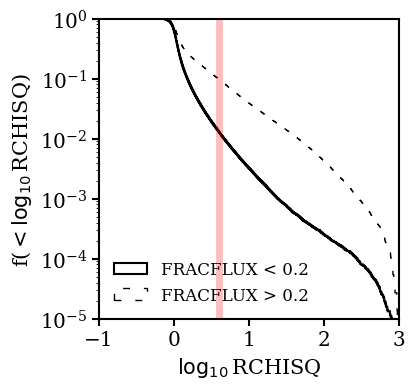

In [62]:
ax = make_subplots(ncol = 1, nrow = 1)
ax[0].hist( np.log10(all_rchisqs_good), bins=1000,range=(-1,3), cumulative=-1,density=True,
           histtype = "step",lw=1.5,color = "k",rasterized=True,label = "FRACFLUX < 0.2")

ax[0].hist( np.log10(all_rchisqs_bad), bins=1000,range=(-1,3), cumulative=-1,density=True,
           histtype = "step",lw=1,color = "k",rasterized=True,ls = (0, (5, 10)), label = "FRACFLUX > 0.2")

ax[0].set_yscale("log")
ax[0].set_xlim([-1,3])
ax[0].legend(frameon=False,loc = "lower left",fontsize = 12)
ax[0].set_ylim([1e-5,1])
ax[0].set_xlabel(r"$\log_{10}$RCHISQ",fontsize = 15)
ax[0].set_ylabel(r"f($<\log_{10}$RCHISQ)",fontsize = 15)
ax[0].axvline(np.log10(4), color="r",alpha = 0.25,lw = 5)

plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/rchisq_dist.pdf",bbox_inches="tight")
plt.show()

In [63]:
## let us visualy inspect the BGS Bright ones to show some pretty plots!!
out = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_bgs_bright_filter_zsucc_zrr02_allfracflux.fits")


In [89]:
rchisq_cut = 100
rchisq_mask = ( out["RCHISQ_G"] > rchisq_cut ) | ( out["RCHISQ_R"] > rchisq_cut ) | ( out["RCHISQ_Z"] > rchisq_cut )

print(np.sum(rchisq_mask))
print(np.sum(rchisq_mask)/len(out))


110
0.000617100413457277


In [90]:
print_radecs(out[rchisq_mask]["RA","DEC"], ra="RA",dec="DEC",num=300)

33.54616961683835 17.61251364880974
145.81021914087296 40.645199862270786
154.56401180611363 46.44100602478375
140.60142556272734 47.24561699683317
154.8641408873874 47.6471689418299
171.9765505645383 51.60405737378118
152.84551963469863 52.703992612812
113.05770156659275 42.66546268931356
109.29751839368501 41.81754089943985
105.34094608476629 44.05854724059293
105.34756687236855 44.67647422805851
112.96108946570627 46.53500582484092
107.79260744327398 49.89979549658146
94.7414865111992 62.858628651132705
95.38396159525932 62.64354069082957
138.64564864091275 47.0356247198666
100.57641462834366 63.9124160229589
97.47074052324407 68.99247981455638
227.75557488966635 31.479247593006434
231.55141261242144 32.44936462511856
254.78219846341966 32.52448830995376
245.78381824170452 35.7415495014024
259.4989175497293 33.33445254715888
263.1455991033341 41.613706642690815
241.37153063019764 35.825916365724154
239.01367299876588 47.57487179772496
265.89564791968616 59.96197934893072
214.5797300

In [85]:
ras_bad_rchisq = np.array([
    325.77828715625105,
    137.33639489452136,
    127.68492588941022,
    161.24081749569075,
    5.720770547145609,
    65.20590404113857, 
    230.5611911416743,
    136.7128109117229,
    46.021750816066934
])


decs_bad_rchisq = [
    23.379120576982093,
    -1.7893384723768473,
    2.4321683794488527,
    3.886996381136422,
    7.224984949195506,
    -13.733522134796548,
    31.47569235750885,
    77.64959217747678,
    -13.365773525656
]

print(len(ras_bad_rchisq), len(decs_bad_rchisq))


out_very_bad = out[rchisq_mask]

9 9


In [88]:
zreds_bad_rchisq = []
for ra_i in ras_bad_rchisq:
    zred_i = out_very_bad[out_very_bad["RA"] == ra_i]["Z"][0]
    print(out_very_bad[out_very_bad["RA"] == ra_i]["FRACFLUX_G","FRACFLUX_R","FRACFLUX_Z"])
    # print(zred_i)
    zreds_bad_rchisq.append(zred_i)    

 FRACFLUX_G FRACFLUX_R  FRACFLUX_Z
----------- ---------- -----------
0.067547634 0.06850166 0.054636683
FRACFLUX_G FRACFLUX_R FRACFLUX_Z
---------- ---------- ----------
0.02254453 0.03571162 0.03991695
FRACFLUX_G FRACFLUX_R FRACFLUX_Z
---------- ---------- ----------
0.16182782  0.1771842  0.2589302
 FRACFLUX_G  FRACFLUX_R FRACFLUX_Z
----------- ----------- ----------
0.028819304 0.030808317 0.07223896
 FRACFLUX_G  FRACFLUX_R  FRACFLUX_Z
----------- ----------- -----------
0.046129137 0.033575453 0.012485556
 FRACFLUX_G   FRACFLUX_R     FRACFLUX_Z 
----------- -------------- -------------
1.27559e-05 1.47212895e-05 2.6498266e-05
FRACFLUX_G FRACFLUX_R FRACFLUX_Z
---------- ---------- ----------
 0.8304483 0.63856727 0.77760917
FRACFLUX_G FRACFLUX_R FRACFLUX_Z
---------- ---------- ----------
 1.7085854  1.5571735  1.3923827
FRACFLUX_G FRACFLUX_R FRACFLUX_Z
---------- ---------- ----------
0.29433924 0.39285848  0.5132614


/pscratch/sd/v/virajvm/trash/plotting_cutouts/image_grz_ra_230.561_dec_31.476.fits
/pscratch/sd/v/virajvm/trash/plotting_cutouts/image_grz_ra_136.713_dec_77.650.fits
/pscratch/sd/v/virajvm/trash/plotting_cutouts/image_grz_ra_46.022_dec_-13.366.fits


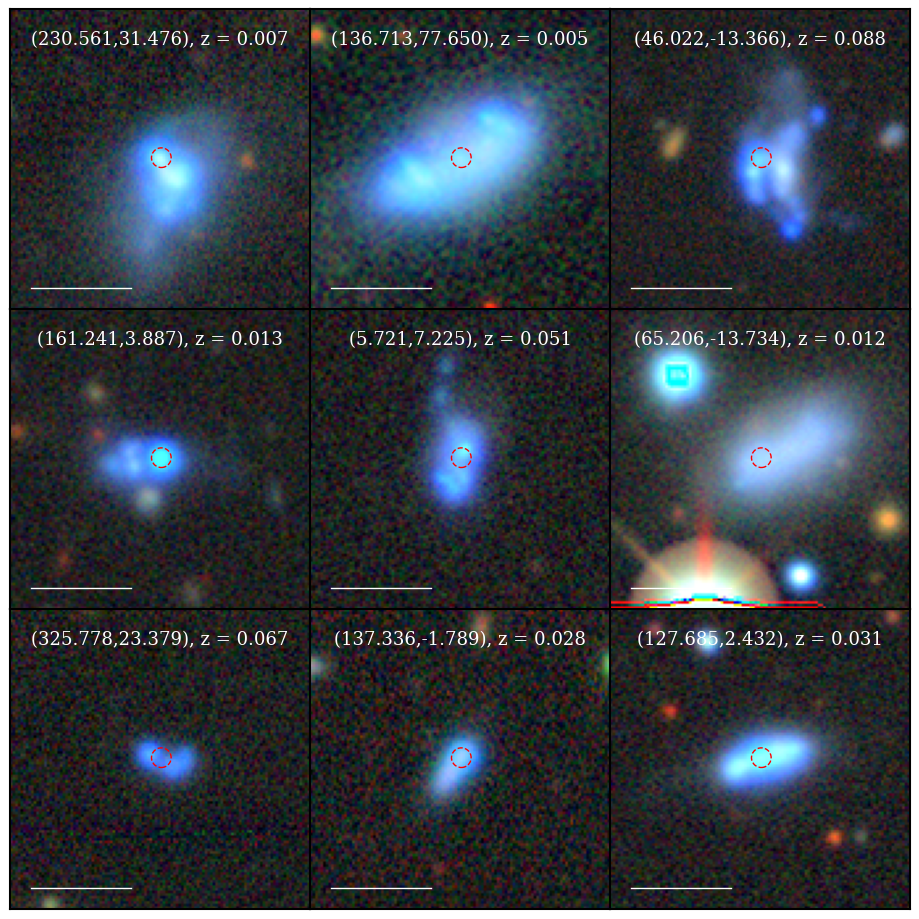

In [87]:
img_folder = "/pscratch/sd/v/virajvm/trash/plotting_cutouts"

make_cool_grz_panel(ncol=3,nrow =3, ras=ras_bad_rchisq,decs=decs_bad_rchisq, zreds = zreds_bad_rchisq, cutout_sizes=[30,30,30,30,30,30,30,30,30],
                        bar_size = 10, plot_bar = True, img_paths = None, save_img_fold = img_folder,
                       col_spacing = 0.0, row_spacing = 0.0,markersize=200, plot_title = True,
                    save_path="/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/bad_rchisq_dwarfs.pdf")


In [181]:
# out[out["TARGETID"] == 39628448083216003]["IMAGE_PATH","RA","DEC"]

In [161]:
# fits.open("/pscratch/sd/v/virajvm/redo_photometry_plots/all_good_cutouts/image_tgid_39628448083216003_ra_114.214_dec_28.485.fits")

In [180]:
# import requests
# session = requests.Session()

# save_cutouts(114.21378175817877, 28.48462569865051,"/pscratch/sd/v/virajvm/trash/temp.fits" , session,size=150 )
# data = fits.open("/pscratch/sd/v/virajvm/trash/temp.fits")
# plt.imshow(data[0].data[0],norm=LogNorm())
##^^investingating whether these blue trails are masked. They are not masked but that is okay for now!

In [103]:
temp_cat = out[out["Z"] < 0.05]["SHAPE_R","Z","Z_CMB","LOGM_SAGA_FIDU","RA","DEC","MAG_R"]
print(len(temp_cat))
###can I convert a radius in arcseconds t 
# temp_cat = temp_cat[ temp_cat["SHAPE_R"]!= 0 ]
print(len(temp_cat))

from astropy.cosmology import Planck18

def arcsec_to_kpc(zreds, shape_r):
    arcsec_to_rad = (np.pi / 180.0) / 3600.0
    kpc_size = Planck18.angular_diameter_distance(zreds).to(u.kpc).value * arcsec_to_rad * shape_r
    return kpc_size
    

94073
94073


In [104]:
kpc_sizes = arcsec_to_kpc(temp_cat["Z_CMB"], temp_cat["SHAPE_R"])

In [105]:
np.min(kpc_sizes), np.max(kpc_sizes)

(0.0, 13.37781744806328)

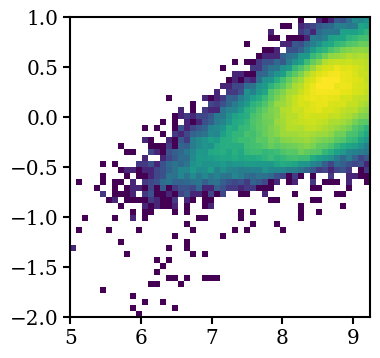

In [99]:


fig,ax = make_subplots(nrow = 1, ncol = 1, return_fig=True)
ax[0].hist2d(temp_cat["LOGM_SAGA_FIDU"], np.log10(kpc_sizes),bins=50,range = ( (5,9.25), (-2,1) ),norm=LogNorm() )
ax[0].set_xlim([5,9.25])
ax[0].set_ylim([-2,1])
plt.show()

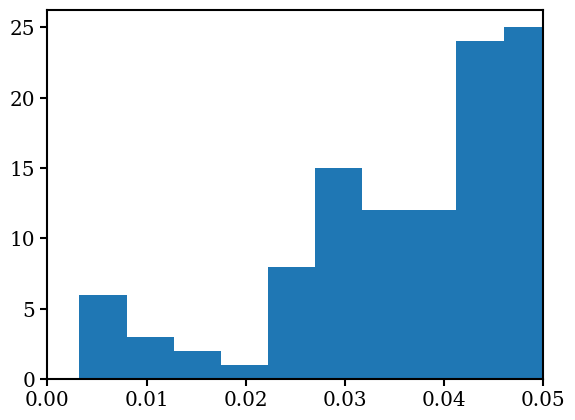

In [111]:
plt.hist(temp_cat[temp_cat["SHAPE_R"] == 0]["Z_CMB"],bins=10)
plt.xlim([0,0.05])
plt.show()

In [113]:
temp_cat[(temp_cat["SHAPE_R"] == 0) & (temp_cat["Z_CMB"] < 0.02)]["RA","DEC"]

<Table length=12>
        RA                 DEC        
       deg                 deg        
     float64             float64      
------------------ -------------------
 315.2931858779731  -2.962352954622406
190.75486768658354  2.6998617953654938
 65.20590404113857 -13.733522134796548
209.06688953186926   5.313609785235641
185.28488433218135  12.413863092057035
235.46087615794616  13.264644902250373
 354.6154948877234  -8.716974985350165
 211.9863609247105  -1.875761548352489
241.49327770238938   1.513929915871217
193.98921050885463   4.254425621516198
 168.9819499144462  41.621967827083644
210.45603045516114   51.44027312930753

In [101]:
# print_radecs(temp_cat[kpc_sizes < 0.1]["RA","DEC"], ra="RA",dec="DEC")

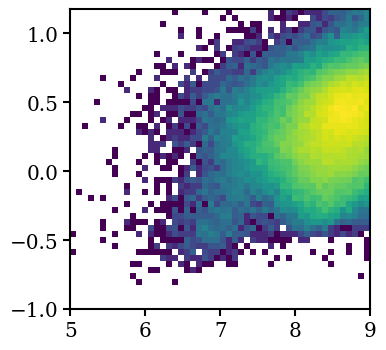

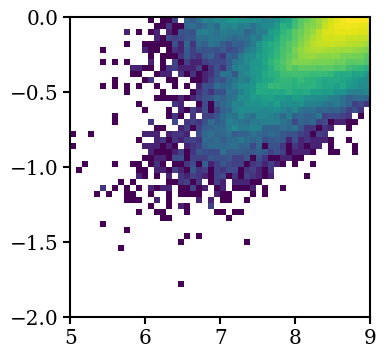

In [87]:

fig,ax = make_subplots(nrow = 1, ncol = 1, return_fig=True)
ax[0].hist2d(temp_cat["LOGM_SAGA_FIDU"], np.log10(temp_cat["SHAPE_R"]),bins=50,range = ( (5,9), (-1,np.log10(15)) ),norm=LogNorm() )
ax[0].set_xlim([5,9])
ax[0].set_ylim([-1,np.log10(15)])
plt.show()


In [19]:
from desi_lowz_funcs import match_c_to_catalog, calc_normalized_dist, get_stellar_mass

In [40]:
#the majority of sources in the sga_match and good tractor catalog are robust!!

In [39]:
# print_radecs(sga_dwarf_robust_trac["RA","DEC"] , ra="RA",dec="DEC")
# we will reprocess stuff

Looking at SGA stuff

In [38]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_desi_SGA_GOOD_matched_dwarfs.fits")
# temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_BGS_BRIGHT_SGA_BAD_TRACTOR_GOOD_matched_dwarfs.fits")

In [40]:


print_radecs(temp["RA","DEC"],ra="RA",dec="DEC",num=500)

#

43.08069199442824 1.9777166572563945
45.10005605837532 2.108033648684944
34.22352518614115 14.633568419066917
31.86551336653497 19.19789867440445
29.63306831166845 22.112789593278947
30.18801262686721 23.75658809337732
35.72989513378572 25.3108308628287
35.04508704600761 29.553621513377138
22.34019114405821 32.068414966704694
12.53865228018465 31.732407853595934
134.30412977935728 3.231550410477893
139.95408572561217 4.484671426437776
134.62393795649146 6.321416958388005
145.47501508372224 11.634075047416925
118.10368967873546 23.507909720981434
132.3521617101919 32.598404287058244
154.77403622190354 34.660886549735324
168.11046765657315 45.26286096774248
168.92277446561002 46.12845058476958
177.94820417392037 46.875998523420684
168.35460558803666 47.57036870009483
173.47971240392565 49.846883636316505
147.74596200260854 35.213373712471856
149.05313748769527 37.07267894856129
148.5801523253523 37.69381694357212
165.03575456717186 50.85617926329394
161.0503843529945 52.27544255800877
16

In [28]:
# temp_1 = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_BGS_BRIGHT_SGA_ALL_BAD.fits")
# temp_2 = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_BGS_FAINT_SGA_ALL_BAD.fits")

# print(len(temp_1), len(temp_2))


272 39


In [24]:
temp_vi = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_desi_sga_bad_trac_bad_VI_NEEDED.fits")

In [25]:
len(temp_vi)

311

In [27]:
print_radecs(temp_vi, ra = "RA", dec = "DEC", num=500)

138.65195742744 8.117661428745901
125.20694950421134 16.653124387511323
126.57526660789544 17.212097521790817
135.06622009419118 35.72038774877094
153.7655820957499 43.00740503266829
169.5902822547336 53.75345315080548
118.99210636979664 26.88649624987347
117.22514933660578 29.06719328793176
115.4843413796215 41.22608540606041
114.05143108998318 41.444834481609256
110.43908973806735 40.4254986721617
110.67281534559264 47.60369937449408
111.83301861232954 52.95527278788766
134.62758430239262 43.89502950701492
135.7048274798092 49.656322507387685
142.86248559433503 69.74733124367103
116.37955565145346 71.21680777254812
125.49355666898907 73.99810196521844
230.40776400768655 8.143515883566907
230.76822544367226 8.609125412560724
241.13522773067513 17.718043954239626
241.34333979347943 17.75044506533041
241.5937558206208 19.77520604403874
241.59908640598405 19.77909072800028
244.84733625541577 30.571580360008564
246.69150492179523 32.34933177248785
254.86384230460075 32.35972279218091
232.

In [103]:
temp_vi_done = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_desi_sga_bad_trac_bad_REPROCESS.fits")

In [106]:
for i in range(len(temp_vi_done)):
    print(f' {i} {temp_vi_done["RA"][i]} {temp_vi_done["DEC"][i]}')

# print_radecs(temp_vi_done, ra = "RA", dec = "DEC", num=500)

 0 126.57526660789544 17.212097521790817
 1 135.06622009419118 35.72038774877094
 2 153.7655820957499 43.00740503266829
 3 169.5902822547336 53.75345315080548
 4 118.99210636979664 26.88649624987347
 5 117.22514933660578 29.06719328793176
 6 115.4843413796215 41.22608540606041
 7 114.05143108998318 41.444834481609256
 8 110.43908973806735 40.4254986721617
 9 111.83301861232954 52.95527278788766
 10 134.62758430239262 43.89502950701492
 11 135.7048274798092 49.656322507387685
 12 116.37955565145346 71.21680777254812
 13 230.40776400768655 8.143515883566907
 14 230.76822544367226 8.609125412560724
 15 241.13522773067513 17.718043954239626
 16 244.84733625541577 30.571580360008564
 17 246.69150492179523 32.34933177248785
 18 254.86384230460075 32.35972279218091
 19 232.66543617363968 33.92853523913546
 20 195.0311530657815 27.958075229699638
 21 203.57183997847565 31.288369503266733
 22 195.96899864605214 32.23439714913377
 23 208.8487170633855 34.253588228925395
 24 213.70291382439774 35

In [113]:
sga_no_photo_dwarf_inds = np.array([1, 2, 12, 29, 48, 71, 100, 114, 122, 125, 154, 159, 162, 170, 181  ])

In [114]:
plot_ras = temp_vi_done[sga_no_photo_dwarf_inds]["RA"].data
plot_decs = temp_vi_done[sga_no_photo_dwarf_inds]["DEC"].data
plot_zreds = temp_vi_done[sga_no_photo_dwarf_inds]["Z"].data

plot_sizes = len(plot_ras) * [90]

plot_sizes[-5] = 180

plot_sizes[-9] = 180


In [117]:
plot_sizes

[90, 90, 90, 90, 90, 90, 180, 90, 90, 90, 180, 90, 90, 90, 90]

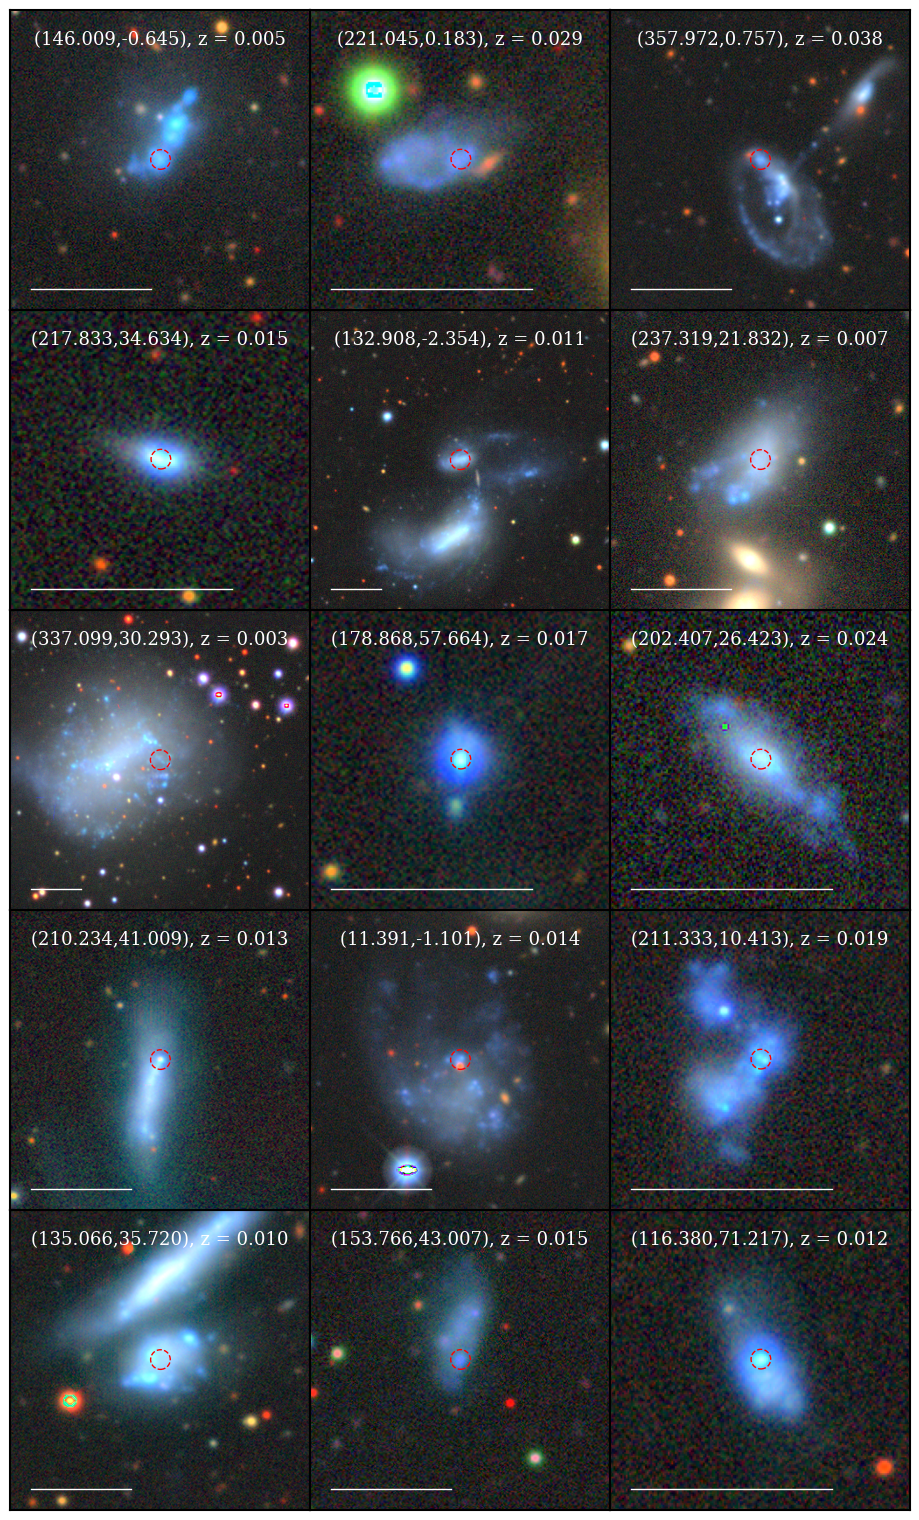

In [121]:
img_folder = "/pscratch/sd/v/virajvm/trash/plotting_cutouts"

make_cool_grz_panel(ncol=3,nrow =5, ras=plot_ras,decs=plot_decs, zreds = plot_zreds, cutout_sizes=[90, 75, 45, 90, 90, 45, 180, 45, 45, 45, 180, 90, 75, 45, 90],
                        bar_size = 30, plot_bar = True, img_paths = None, save_img_fold = img_folder,
                       col_spacing = 0.0, row_spacing = 0.0,markersize=200, plot_title = True,
                    save_path="/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/sga_all_bad_VI_shred_dwarfs.pdf")


Need to validate that all files have been downloaded!!

In [5]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits")

In [8]:

def check_how_many_files(clean=True):
    if clean:
        out = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_clean_catalog_v4.fits") 
        # out = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_clean_catalog_v4_RUN_W_APER.fits")
        out = out[(out["RCHISQ_R"] < 4 ) & (out["RCHISQ_G"] < 4 )  & (out["RCHISQ_Z"] < 4 )   ]
    else:
        out = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits") 

    print("TOTAL NUMBER = ", len(out))
    
    # out = out #just trying with the first one hundred or so
    #use this to make the file names using objid
    allra = np.array(out["RA"],dtype = object)
    alldec = np.array(out["DEC"],dtype = object)
    allobjids = np.array(out["TARGETID"],dtype = object)
    allsizes = np.array(out["IMAGE_SIZE_PIX"],dtype = object)

    if clean:
        outdir_data="/pscratch/sd/v/virajvm/redo_photometry_plots/all_good_cutouts_temp"
    else:
        outdir_data="/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts"
    
    no_file_inds = []
    for k in trange(len(allobjids)):
        if clean:
            file_i = outdir_data + f"/image_tgid_{allobjids[k]:d}_ra_{allra[k]:.3f}_dec_{alldec[k]:3f}.fits"
        else:
            file_i = outdir_data + f"/image_tgid_{allobjids[k]:d}_ra_{allra[k]:.3f}_dec_{alldec[k]:.3f}.fits" 
            
        
        if os.path.exists(file_i):
            pass
        else:    
            no_file_inds.append(k)

    print(len(no_file_inds))
        
    return

            

In [9]:
check_how_many_files()


KeyboardInterrupt



In [3]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits")



In [62]:
# temp[(temp["SAMPLE"] == "BGS_BRIGHT")]["RA","DEC"]

In [63]:
temp[temp["TARGETID"] == 39627944548634404]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes128' length=1>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-180p005-190p010/1801p065/LOWZ_tgid_39627944548634404

In [65]:
temp[temp["TARGETID"] == 39632956775467425]["STARFDIST","STARMAG"]

<Table length=1>
STARFDIST STARMAG 
 float32  float32 
--------- --------
0.5930514 4.784998

In [7]:
temp[temp["TARGETID"] == 39627403307255583]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes128' length=1>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-020m020-030m015/0224m160/BGS_BRIGHT_tgid_39627403307255583

In [11]:
temp[temp["Z"] < 0.002]["RA","DEC"]

<Table length=25>
        RA                 DEC        
       deg                 deg        
     float64             float64      
------------------ -------------------
147.85868544188483 -3.6635682707877586
192.51768307364085  6.8471384463339895
163.02467301304011   36.47784924936974
192.74981568457306   41.19271544157833
198.78296501451587   42.00296419822978
157.13768147748846  42.668592231642656
  110.175846737282  44.037184939644064
203.51389853429757   47.90855896825101
 203.5159765283946   47.90305041334762
               ...                 ...
128.49711108753132 -2.0373136965180083
140.35177573752523   0.698720765266975
163.74173003532243   9.304413029817606
 134.4705006649204 -0.6902662463047313
188.25640338731984  31.523614347729875
186.39988625602817   33.51814303801134
186.50683173279256   33.60988596879402
183.95880508663222  36.365968802164176
 183.9860523183645  36.334482167548536
 183.9027599863354  36.378180683014094

In [31]:
sga_file = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_desi_SGA_matched_dwarfs_REPROCESS.fits")

In [42]:
sga_file[sga_file["TARGETID"] == 39627871567745481]["FILE_PATH"]

<Column name='FILE_PATH' dtype='bytes116' length=1>
/pscratch/sd/v/virajvm/redo_photometry_plots/all_sga/south/sweep-130p000-140p005/1368p035/SGA_tgid_39627871567745481

In [40]:
print_radecs(sga_file[sga_file["Z"] < 0.002]["RA","DEC"],ra="RA",dec="DEC")

133.12847002619654 33.38881702390804
149.1919007196989 28.828759948044837
154.67968459216263 46.04540463665452
151.8202846729595 47.00756324461009
107.55193446717281 44.46056777881356
151.37511220028262 70.36687338000911
232.40761178695573 48.850691228555185
190.40941540152585 32.52849266620707
190.45196741663293 32.537464911914306
191.10358341600903 34.3760680006787
187.15901231079565 35.72042859038426
187.16616694318475 35.72067742612894
188.1889823459343 37.614620465581
196.44186335374633 37.6045194960811
196.46106896507322 37.602896323846345
196.50105948758195 37.602133514632186
196.4564083254884 37.626524621046634
198.21332329583052 40.5430214228219
198.46965920691903 42.20251401202602
184.4541957039922 47.40976021942864
184.4597193311397 47.40910896273631
184.60126103383584 47.38620861784668
180.74287137072878 47.6531023871802
203.34721567880985 49.10451116471639
192.09208577196006 51.15888749275122
188.65558002041192 68.3424875376891
150.4090647002834 -8.248699545932409
152.7361

In [62]:
temp = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags_chunk_24.fits")


In [65]:
temp["RA","DEC","FILE_PATH"]

<Table length=509>
        RA         ...
       deg         ...
     float64       ...
------------------ ...
233.29940780305145 ...
 233.4820464343902 ...
233.82052253248486 ...
234.81765331162913 ...
234.93244097303713 ...
234.93787021977357 ...
235.13987318947468 ...
235.15211430209317 ...
 235.5166492889336 ...
               ... ...
222.09273164385812 ...
 222.3378103332743 ...
 222.5975069200722 ...
222.78465886822264 ...
223.01865450203027 ...
223.43331573222977 ...
223.76073395110822 ...
 225.3116097351427 ...
225.36000799997328 ...
 225.4279275220111 ...